### 3명의 얼굴을 학습하여 인식하기

In [1]:
# Module
import numpy as np
from PIL import Image
import glob

---
### 전체 사진중 최대 해상도 찾기

In [2]:
dirNames = ['Aiden', 'Andrew', 'Cathy']

In [3]:
widthRatio = []
heightRatio = []

for name in dirNames:
    for file in sorted(glob.glob(f"/kaggle/input/data-face/{name}/image*.jpg")):
        img = np.array(Image.open(file))
        widthRatio.append(img.shape[1])
        heightRatio.append(img.shape[0])

In [4]:
print('너비 최대 해상도 :', np.max(widthRatio))
print('높이 최대 해상도 :', np.max(heightRatio))

너비 최대 해상도 : 299
높이 최대 해상도 : 381


> 해상도의 크기를 400 X 300

---
### 전체 사진을 흑백으로 변경하고 검은색 배경(400X300)의 중앙에 일치 시켜 저장하기 

In [5]:
# 작업 폴더 생성 
import os
os.mkdir("./Face")
os.mkdir("./Face/Gray")

In [6]:
# 이름별 directory 생성

for name in dirNames:
    os.mkdir(f"./Face/Gray/{name}")

In [7]:
for name in dirNames:
    fileCount = 0
    for file in sorted(glob.glob(f"/kaggle/input/data-face/{name}/image*.jpg")):
        img = Image.open(file)
        imgResize = img.convert('L')
        imgArray = np.array(imgResize)

        imgDummy = np.zeros(400*300).reshape(400, 300)

        rowNum = (400 - imgArray.shape[0]) / 2
        colNum = (300 - imgArray.shape[1]) / 2

        k = 0
        for i in list(range(int(rowNum), int(rowNum) + imgArray.shape[0])):
            l = 0
            for j in list(range(int(colNum), int(colNum) + imgArray.shape[1])):
                imgDummy[i,j] = imgArray[k,l]
                l +=1
            k +=1
        img2 = Image.fromarray(imgDummy.astype('uint8'), 'L')
        img2.save(f"/kaggle/working/Face/Gray/{name}/image_{fileCount:04d}.jpg","JPEG")
        fileCount +=1

### 사진들을 numpy배열을 이용하여 Training Data 만들기

In [8]:
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 400

In [9]:
train_data = np.zeros(number_of_data * img_width_size * img_height_size).reshape(number_of_data, img_height_size, img_width_size)
i = 0

for name in dirNames:
    for file in sorted(glob.glob(f"/kaggle/working/Face/Gray/{name}/*.jpg")):
        img = np.array(Image.open(file))
        train_data[i,:,:] = img
        i+=1

In [10]:
train_data.shape

(54, 400, 300)

### 이미지 확인

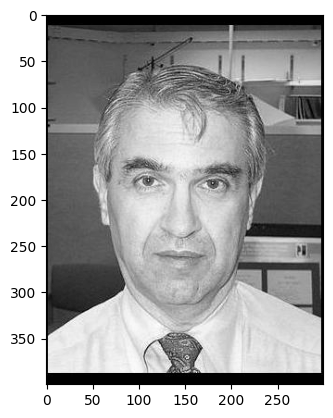

In [11]:
import matplotlib.pyplot as plt

plt.imshow(train_data[20], cmap='gray')
plt.show()

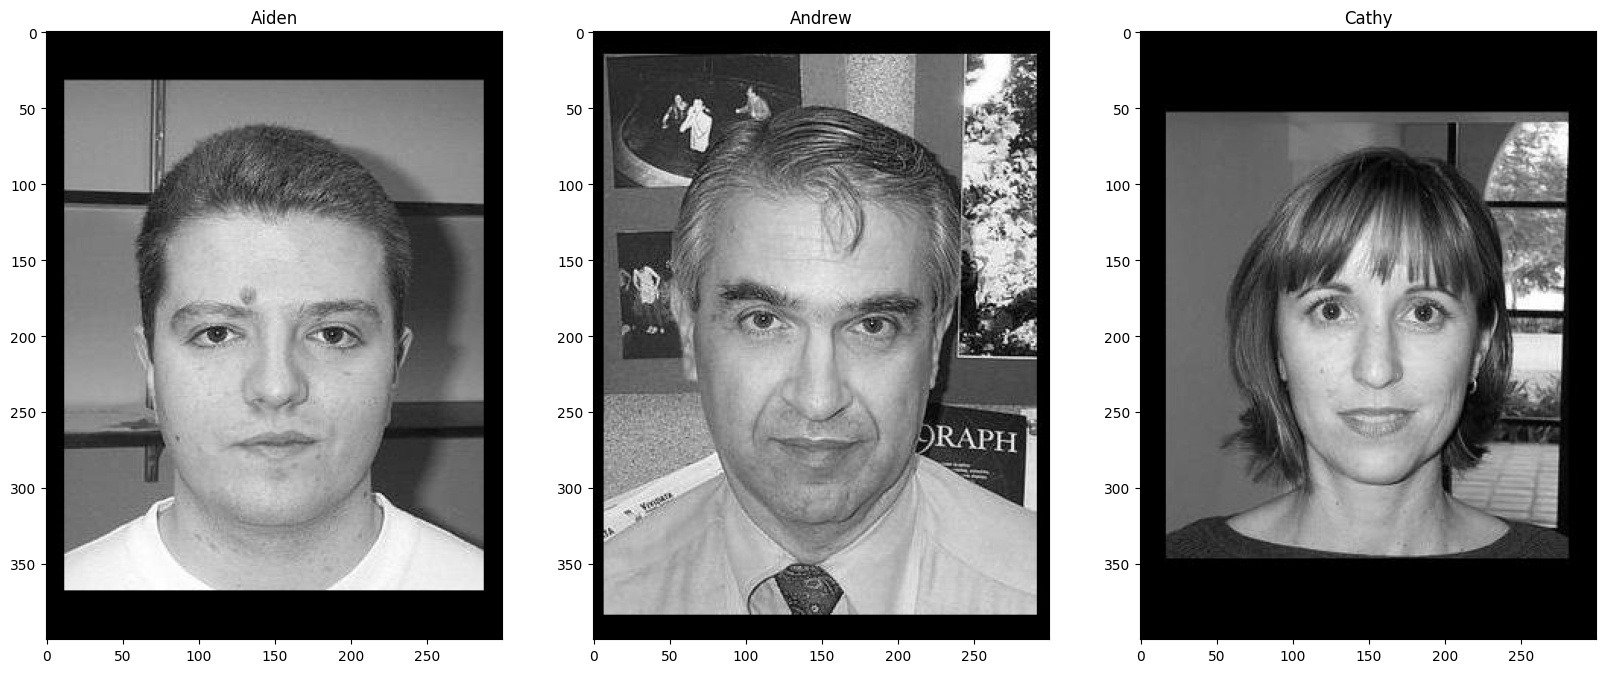

In [12]:
# 여러개의 이미지를 같이 보기
plt.figure(figsize=(20, 20))
orderNo = list(range(0, len(dirNames)*18, 18))

for i in list(range(1, len(dirNames)+1)):
    plt.subplot(1, len(dirNames), i)
    plt.imshow(train_data[orderNo[i-1]].reshape(400, 300), cmap='gray')
    plt.title(dirNames[i-1])



### Target Data만들기

In [13]:
# a = [0 for _ in range(18)]
# b = [1 for _ in range(18)]
# c = [2 for _ in range(18)]
# target_data = a + b + c

target_data = [num for num in range(3) for _ in range(18)]
print(target_data)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


---
### Data들을 Tensor로 변환

In [14]:
import torch

train_input = torch.tensor(train_data)
train_target = torch.tensor(target_data)

print(train_input.data.shape)
print(train_target.data.shape)

torch.Size([54, 400, 300])
torch.Size([54])


### train data를 훈련데이터와 검증데이터로 나누기 (정규화, 채널 추가)

In [15]:
from sklearn.model_selection import train_test_split

train_input = train_input.data.unsqueeze(1).float() / 255.0 # 채널 차원 및 정규화
train_input, val_input, train_target, val_target = train_test_split(
                                                        train_input,
                                                        train_target,
                                                        test_size=0.2,
                                                        random_state=42
)

In [16]:
# Dimension 확인
print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)

torch.Size([43, 1, 400, 300]) torch.Size([43])
torch.Size([11, 1, 400, 300]) torch.Size([11])


--- 
### CNN 신경망 만들기

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [18]:
# Dataset 및 DataLoader 생성
batch_size = 32 # mini batch
train_dataset = TensorDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### 모델 정의

In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 100 * 75, 128) # 64, (400/4), (300/4)
        self.relu3 = nn.ReLU()
        # self.dropout = nn.Dropout(0.9)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        # x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [22]:
# 모델, 손실함수, 옵티마이저 초기화
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [23]:
# 학습 함수
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 이전 반복에서 계산된 그레디언트를 초기화 
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward() # 손실에 대한 그레디언트를 계산하고 역전파 
        optimizer.step() 
    return loss.item()

In [24]:
# 평가함수
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return total_loss / len(val_loader), correct / total

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480000, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [26]:
# 훈련 반복

train_loss_scores = [] # train score list
val_loss_scores = [] # test score list

num_epochs = 50

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    train_loss_scores.append(train_loss)
    val_loss_scores.append(val_loss)
    print(f'Epoch : [{epoch+1} / {num_epochs}], Train Loss : {train_loss:.4f}, Val Loss : {val_loss:.4f}, Val Accuracy : {val_accuracy:.4f}')

Epoch : [1 / 50], Train Loss : 12.1681, Val Loss : 4.3084, Val Accuracy : 0.8182
Epoch : [2 / 50], Train Loss : 6.5899, Val Loss : 1.3285, Val Accuracy : 0.4545
Epoch : [3 / 50], Train Loss : 1.0771, Val Loss : 2.1247, Val Accuracy : 0.3636
Epoch : [4 / 50], Train Loss : 0.0754, Val Loss : 0.0603, Val Accuracy : 1.0000
Epoch : [5 / 50], Train Loss : 0.0159, Val Loss : 0.4234, Val Accuracy : 0.9091
Epoch : [6 / 50], Train Loss : 0.0854, Val Loss : 0.3864, Val Accuracy : 0.9091
Epoch : [7 / 50], Train Loss : 0.0327, Val Loss : 0.1871, Val Accuracy : 0.9091
Epoch : [8 / 50], Train Loss : 0.0014, Val Loss : 0.9854, Val Accuracy : 0.7273
Epoch : [9 / 50], Train Loss : 0.0035, Val Loss : 0.2584, Val Accuracy : 0.9091
Epoch : [10 / 50], Train Loss : 0.0177, Val Loss : 0.4001, Val Accuracy : 0.8182
Epoch : [11 / 50], Train Loss : 0.0019, Val Loss : 1.2156, Val Accuracy : 0.8182
Epoch : [12 / 50], Train Loss : 0.0012, Val Loss : 0.2461, Val Accuracy : 0.9091
Epoch : [13 / 50], Train Loss : 0.00

In [27]:
# 훈련 데이터로 평가
train_loss, train_accuracy = evaluate(model, train_loader, criterion, device)
print(f'Training Loss : {train_loss:.4f}, Training Accuracy : {train_accuracy:.4f}')

Training Loss : 0.0000, Training Accuracy : 1.0000


In [28]:
# 검증 데이터로 평가
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
print(f'Validation Loss : {val_loss:.4f}, Validation Accuracy : {val_accuracy:.4f}')

Validation Loss : 0.4669, Validation Accuracy : 0.9091


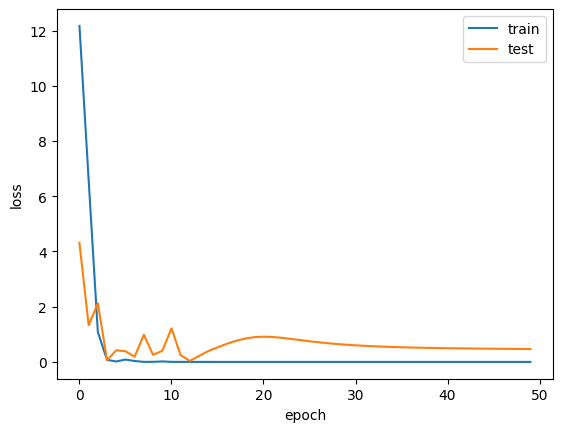

In [32]:
# 시각화 해보기

plt.plot(train_loss_scores)
plt.plot(val_loss_scores)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

---
### 이미지 불러와서 예측해 보기

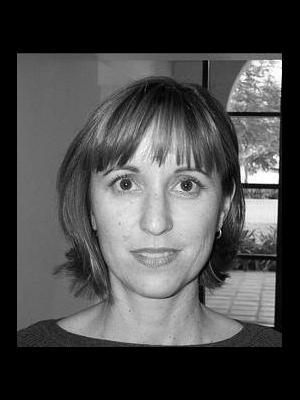

In [33]:
# Image
img = Image.open("/kaggle/working/Face/Gray/Cathy/image_0000.jpg")
img

In [34]:
# image를 numpy 배열로 변환
img = np.array(img)
img.shape

(400, 300)

In [35]:
# numpy배열을 torch 변환
img = torch.from_numpy(img)
img.shape

torch.Size([400, 300])

In [36]:
# 정규화 시키기
img = img.unsqueeze(0).float() / 255.0
img.shape

torch.Size([1, 400, 300])

In [38]:
# Class들의 이름 정의
classes = ['Aiden', 'Andrew', 'Cathy']
classes

['Aiden', 'Andrew', 'Cathy']

In [39]:
# 예측 함수
def predict_single_image(model, image, device, classes):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)
        predicted_class = classes[predicted.item()]
    return predicted_class

In [40]:
# 예측 수행
predict_single_image(model, img, device, classes)

'Cathy'

---
### 학습한 모델 저장하기

In [41]:
# 전체 모델 저장
torch.save(model, './cnn_3_persons.pth')

In [43]:
# 전체 모델 불러오기
model1 = torch.load("./cnn_3_persons.pth", weights_only=False)
model1.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=480000, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [44]:
predict_single_image(model1, img, device, classes)

'Cathy'